## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import random
import textwrap
random.seed(29)

## Reading necessary files

In [2]:
# Loading userIDs and newsIDs
userId=np.load('userId.npy')
newsId=np.load('itemId.npy')

# Loading news_embeddings and user_embeddings
news_embedding=np.load('news_embeddings_numpy.npy')
user_embedding=np.load('user_embedding.npy')

In [3]:
# Creating dictionaries for easy code understanding

news={}
for i in range(len(newsId)):
    news[newsId[i]]=news_embedding[i]

user={}
for i in range(len(userId)):
    user[userId[i]]=user_embedding[i]

In [4]:
# Cleaning the read file

def clean(impList):
    return ast.literal_eval(impList)

behave = pd.read_csv('behaviours_list.csv')
behave['impList'] = behave['impList'].map(clean)
behave['clickList'] = behave['clickList'].map(clean)
behave['noClickList'] = behave['noClickList'].map(clean)

In [5]:
news_data = pd.read_csv("preprocessed_news.csv")
news_data.head()

,itemId,category,subcategory,title,abstract,url,combined,processed,processed2
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,lifestyle lifestyleroyals The Brands Queen Eli...,"['lifestyle', 'lifestyleroyals', 'brand', 'que...",lifestyle lifestyleroyals brand queen elizabet...
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,health weightloss 50 Worst Habits For Belly Fa...,"['health', 'weightloss', 'bad', 'habit', 'bell...",health weightloss bad habit belly fat seemingl...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,news newsworld The Cost of Trump's Aid Freeze ...,"['news', 'newsworld', 'cost', 'trump', 'aid', ...",news newsworld cost trump aid freeze trench uk...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,health voices I Was An NBA Wife. Here's How It...,"['health', 'voice', 'nba', 'wife', 'affect', '...",health voice nba wife affect mental health fel...
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"health medical How to Get Rid of Skin Tags, Ac...","['health', 'medical', 'get', 'rid', 'skin', 't...",health medical get rid skin tag accord dermato...


## Models

In [6]:
# BPR : Approach 1
class BPR1:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.W = np.random.normal(size=(1, 384)) / 100
    
    def fit(self, interactions, epochs=10):
        for epoch in tqdm(range(epochs)):
            # Shuffle the interactions
            np.random.shuffle(interactions)
            count = 0
            cost = 0
            grad = 0
            for u, l, d, label in interactions:
                u = u.reshape(-1, 1)
                l = l.reshape(-1, 1)
                d = d.reshape(-1, 1)
                count += 1
                if label:
                    loss = self.calculate_loss(u, l, d)
                    cost += loss
                    grad -= (1 - self.calculate_grad(u, l, d)) * (u * (l - d)).T
                else:
                    loss = self.calculate_loss(u, d, l)
                    cost += loss
                    grad -= (1 - self.calculate_grad(u, d, l)) * (u * (d - l)).T
            
            # Gradient descent
            self.W -= self.learning_rate * grad / count
            
            # Printing the cost after each epoch
            cost /= count
            print("Epoch:", epoch, "Cost:", cost)

    def calculate_loss(self, u, l, d):
        return np.log(1 + np.exp(-np.dot(self.W, u * (l - d))))
    
    def calculate_grad(self, u, l, d):
        return 1 / (1 + np.exp(-np.dot(self.W, u * (l - d))))
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, interactions, ts = 0.5):
        # Returns number of (True positives, False positives, False negatives, True negatives)
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for u, l, d, label in interactions:
            temp = self.calculate_grad(u, l, d)
            pred = 1 if temp > ts else 0
            if pred == 1:
                if label == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if label == 1:
                    fn += 1
                else:
                    tn += 1
        return (tp, fp, fn, tn)
    
    def predictOne(self, interactions, ts = 0.5):
        # Returns 0 or 1 for a single row
        for u, l, d in interactions:
            temp = self.calculate_grad(u, l, d)
            pred = 1 if temp > ts else 0
            return pred

In [7]:
# BPR : Approach 2
class BPR2:
    def __init__(self, dimension=10, learning_rate=0.05):
        self.dim = dimension
        self.learning_rate = learning_rate
        self.Wu = np.random.normal(size=(self.dim, 384)) / 1000
        self.Wa = np.random.normal(size=(self.dim, 384)) / 1000
    
    def fit(self, interactions, epochs=10):
        for epoch in tqdm(range(epochs)):
            # Shuffle the interactions
            np.random.shuffle(interactions)
            count = 0
            uSum = 0
            aSum = 0
            cost = 0
                        
            for u, l, d, label in interactions:
                u = u.reshape(-1, 1)
                l = l.reshape(-1, 1)
                d = d.reshape(-1, 1)
                
                uc = np.dot(self.Wu, u)
                lc = np.dot(self.Wa, l)
                dc = np.dot(self.Wa, d)
                
                count += 1
                if label:
                    cost += self.calculate_loss(uc, lc, dc)
                    temp = self.calculate_grad(uc, lc, dc)
                    uSum += - (1 - temp) * np.dot(lc - dc, u.T)
                    aSum += - (1 - temp) * np.dot(uc, (l - d).T)
                else:
                    cost += self.calculate_loss(uc, dc, lc)
                    temp = self.calculate_grad(uc, dc, lc)
                    uSum += - (1 - temp) * np.dot(dc - lc, u.T)
                    aSum += - (1 - temp) * np.dot(uc, (d - l).T)

            # Gradient descent
            self.Wu -= self.learning_rate * uSum / count
            self.Wa -= self.learning_rate * aSum / count
            
            # Print the cost after each epoch
            cost /= count
            print("Epoch:", epoch, "Cost:", cost)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def calculate_loss(self, u, l, d):
        return np.log(1 + np.exp(-np.dot(u.T, l - d)))
    
    def calculate_grad(self, u, l, d):
        return 1 / (1 + np.exp(-np.dot(u.T, l - d)))
    
    def predict(self, interactions, ts = 0.5):
        # Returns number of (True positives, False positives, False negatives, True negatives)
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for u, l, d, label in interactions:
            temp = self.sigmoid(np.dot(np.dot(self.Wu, u), np.dot(self.Wa, l - d)))
            pred = 1 if temp > ts else 0
            if pred == 1:
                if label == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if label == 1:
                    fn += 1
                else:
                    tn += 1
        return (tp, fp, fn, tn)
    
    def predictOne(self, interactions, ts = 0.5):
        # Returns 0 or 1 for a single row
        for u, l, d in interactions:
            temp = self.sigmoid(np.dot(np.dot(self.Wu, u), np.dot(self.Wa, l - d)))
            pred = 1 if temp > ts else 0
            return pred

## Helper Functions

In [8]:

# Function for creating dataset in the required format
def createData(IDList):
    interactions = []
    for id in IDList:
        usd = behave[behave.userId == id]
        for i in list(usd.index.values):
            for j in usd['clickList'][i]:
                for k in usd['noClickList'][i]:
                    label = random.randint(0, 1)
                    if label: 
                        interactions.append([user[id], news[j], news[k], label])
                    else:
                        interactions.append([user[id], news[k], news[j], label])
    return interactions

# Function for displaying recommendations
def displayBPR(display_list):
    for article in display_list:
        temp = news_data[news_data['itemId'] == article][["itemId", 'title', 'abstract', "category"]]
        for i in temp.index.values:
            print("\t", temp["itemId"][i], "\t", temp["category"][i], "\t", temp["title"][i])
            abstractText = "\t\t\t\t" + temp["abstract"][i]
            print('\n\t\t\t\t'.join(textwrap.wrap(abstractText, 60, break_long_words=False)))
            print()
            
# Ranks articles for a specific user
def rankArticles(model, ts, username, setSize, displaySize):
    rank_list={}
    
    for i in range(len(newsId[:setSize])):
        rank_list[newsId[i]] = 0
            
    for i in range(len(newsId[:setSize])):
        for j in range(i + 1, len(newsId[:setSize])):
            score = model.predictOne([[user[username], news[newsId[i]], news[newsId[j]]]], ts)
            rank_list[newsId[i]] += score
            rank_list[newsId[j]] += 1 - score
        
    keys = list(rank_list.keys())
    values = list(rank_list.values())
    sorted_value_index = np.argsort(values)
    key_list = [keys[i] for i in sorted_value_index]
    values_list = [values[i] for i in sorted_value_index]
    key_list.reverse()
    displayBPR(key_list[:displaySize])

In [9]:
# Functions for calculating accuracy metrics

def calculatePrecision(numbers):
    return numbers[0] / (numbers[0] + numbers[1])

def calculateRecall(numbers):
    return numbers[0] / (numbers[0] + numbers[2])

def calculateSpecificity(numbers):
    return numbers[3] / (numbers[3] + numbers[1])

def calculateF1Score(precision, recall):
    return 2 * precision * recall / (precision + recall)

def calculateMetrics(pred):
    precision = calculatePrecision(pred)
    recall = calculateRecall(pred)
    specificity = calculateSpecificity(pred)
    f1_score = calculateF1Score(precision, recall)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("Specificity = ", specificity)
    print("F1 score = ", f1_score)

## Datsets Generation

In [42]:
IDList = []
# IDList = ['U7854', 'U5452', 'U3258', 'U25463', 'U9494', 'U9849', 'U9704', 'U9946', 'U63660', 'U8332']

# Below 250 signifies rows corresponding to 250 different random users are made in the train dataset
IDList.extend(list(np.random.choice(userId, size = 250)))
trainDataset = createData(IDList)

In [43]:
testList = []

# Below 250 signifies rows corresponding to 120 different random users are made in the test dataset
testList.extend(list(np.random.choice(userId, size = 120)))
testDataset = createData(testList)

In [44]:
# Number of rows in train dataset
trainDataset.__len__()

51567

In [45]:
# Number of rows in test dataset
testDataset.__len__()

22487

## Training models

In [46]:
# Approach 1
model1 = BPR1()
model1.fit(trainDataset, epochs = 20)

  5%|▌         | 1/20 [00:01<00:22,  1.17s/it]

Epoch: 0 Cost: [[0.69727404]]


 10%|█         | 2/20 [00:02<00:20,  1.15s/it]

Epoch: 1 Cost: [[0.68531465]]


 15%|█▌        | 3/20 [00:03<00:18,  1.12s/it]

Epoch: 2 Cost: [[0.67565285]]


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

Epoch: 3 Cost: [[0.66767741]]


 25%|██▌       | 5/20 [00:05<00:15,  1.06s/it]

Epoch: 4 Cost: [[0.66094791]]


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

Epoch: 5 Cost: [[0.65515679]]


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

Epoch: 6 Cost: [[0.6500891]]


 40%|████      | 8/20 [00:08<00:12,  1.08s/it]

Epoch: 7 Cost: [[0.64559219]]


 45%|████▌     | 9/20 [00:09<00:11,  1.06s/it]

Epoch: 8 Cost: [[0.64155525]]


 50%|█████     | 10/20 [00:10<00:11,  1.10s/it]

Epoch: 9 Cost: [[0.63789596]]


 55%|█████▌    | 11/20 [00:12<00:09,  1.10s/it]

Epoch: 10 Cost: [[0.63455177]]


 60%|██████    | 12/20 [00:13<00:08,  1.12s/it]

Epoch: 11 Cost: [[0.63147422]]


 65%|██████▌   | 13/20 [00:14<00:07,  1.12s/it]

Epoch: 12 Cost: [[0.62862503]]


 70%|███████   | 14/20 [00:15<00:06,  1.10s/it]

Epoch: 13 Cost: [[0.6259735]]


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

Epoch: 14 Cost: [[0.62349463]]


 80%|████████  | 16/20 [00:17<00:04,  1.07s/it]

Epoch: 15 Cost: [[0.62116783]]


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

Epoch: 16 Cost: [[0.61897592]]


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

Epoch: 17 Cost: [[0.61690445]]


 95%|█████████▌| 19/20 [00:20<00:01,  1.07s/it]

Epoch: 18 Cost: [[0.61494114]]


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

Epoch: 19 Cost: [[0.61307548]]


In [47]:
# Approach 2
model2 = BPR2(dimension = 10)
model2.fit(trainDataset, epochs = 10)

 10%|█         | 1/10 [00:02<00:19,  2.18s/it]

Epoch: 0 Cost: [[0.6931278]]


 20%|██        | 2/10 [00:04<00:16,  2.09s/it]

Epoch: 1 Cost: [[0.69285831]]


 30%|███       | 3/10 [00:06<00:14,  2.09s/it]

Epoch: 2 Cost: [[0.69237312]]


 40%|████      | 4/10 [00:08<00:12,  2.08s/it]

Epoch: 3 Cost: [[0.69119686]]


 50%|█████     | 5/10 [00:10<00:10,  2.06s/it]

Epoch: 4 Cost: [[0.68824873]]


 60%|██████    | 6/10 [00:12<00:08,  2.09s/it]

Epoch: 5 Cost: [[0.68138844]]


 70%|███████   | 7/10 [00:14<00:06,  2.07s/it]

Epoch: 6 Cost: [[0.66879739]]


 80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

Epoch: 7 Cost: [[0.65385482]]


 90%|█████████ | 9/10 [00:18<00:02,  2.07s/it]

Epoch: 8 Cost: [[0.64070259]]


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

Epoch: 9 Cost: [[0.62941275]]


## Train Accuracy Metrics

In [48]:
# Approach 1
y_pred_1 = model1.predict(trainDataset, ts = 0.457)
calculateMetrics(y_pred_1)

Precision =  0.6027899150541428
Recall =  0.8564102564102564
Specificity =  0.4289950062421973
F1 score =  0.7075594915740181


In [49]:
# Approach 2
y_pred_2 = model2.predict(trainDataset, ts = 0.418)
calculateMetrics(y_pred_2)

Precision =  0.56934078855799
Recall =  0.9147869674185464
Specificity =  0.29985955056179775
F1 score =  0.701860781587433


## Test Accuracy Metrics

In [50]:
# Approach 1
y_pred_1_t = model1.predict(testDataset, ts = 0.457)
calculateMetrics(y_pred_1_t)

Precision =  0.5561282589151932
Recall =  0.8200618647812639
Specificity =  0.33709273182957394
F1 score =  0.6627857142857142


In [51]:
# Approach 2
y_pred_2_t = model2.predict(testDataset, ts = 0.418)
calculateMetrics(y_pred_2_t)

Precision =  0.5177111716621253
Recall =  0.8563853292090146
Specificity =  0.19199785177228787
F1 score =  0.6453116675546083


## Ranking Articles for a user

Articles are ranked from a set that has first 'setSize' number of articles of news. 'displaySize' top ranked articles for a user ('username') are displayed.

In [52]:
# Approach 1
rankArticles(model1, 0.457, username = 'U8125', setSize = 100, displaySize = 10)

	 N55528 	 lifestyle 	 The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By
                                Shop the notebooks, jackets,
				and more that the royals can't live without.

	 N19639 	 health 	 50 Worst Habits For Belly Fat
                                These seemingly harmless
				habits are holding you back and keeping you from shedding
				that unwanted belly fat for good.

	 N61837 	 news 	 The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War
                                Lt. Ivan Molchanets peeked
				over a parapet of sand bags at the front line of the war in
				Ukraine. Next to him was an empty helmet propped up to trick
				snipers, already perforated with multiple holes.

	 N53526 	 health 	 I Was An NBA Wife. Here's How It Affected My Mental Health.
                                I felt like I was a fraud,
				and being an NBA wife didn't help that. In fact, it nearly
				destroyed me.

	 N49186 	 weather 	 It's been Orlando's h

In [53]:
# Approach 2
rankArticles(model2, 0.418, username = 'U8125', setSize = 100, displaySize = 10)

	 N55528 	 lifestyle 	 The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By
                                Shop the notebooks, jackets,
				and more that the royals can't live without.

	 N19639 	 health 	 50 Worst Habits For Belly Fat
                                These seemingly harmless
				habits are holding you back and keeping you from shedding
				that unwanted belly fat for good.

	 N61837 	 news 	 The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War
                                Lt. Ivan Molchanets peeked
				over a parapet of sand bags at the front line of the war in
				Ukraine. Next to him was an empty helmet propped up to trick
				snipers, already perforated with multiple holes.

	 N53526 	 health 	 I Was An NBA Wife. Here's How It Affected My Mental Health.
                                I felt like I was a fraud,
				and being an NBA wife didn't help that. In fact, it nearly
				destroyed me.

	 N38324 	 health 	 How to Get Rid of Skin

## Plotting ROC curves

In [64]:
import matplotlib.pyplot as plt

# Plots ROC curve and prints are under it
def plotROC(model, dataset, text):
    def calculateArea(rx, ry):
        area = 0.5 * rx[0] * ry[0]
        count = len(rx)
        for i in range(count - 1):
            dA = 0.5 * (rx[i + 1] - rx[i]) * (ry[i] + ry[i + 1])
            area += dA
        return area

    x = []
    y = []
    
    for ts in tqdm(range(0, 10, 1)):
        y_pred = model.predict(dataset, ts / 10)
        specificity = calculateSpecificity(y_pred)
        recall = calculateRecall(y_pred)
        x.append(1 - specificity)
        y.append(recall)
    x.reverse()
    y.reverse()    
    plt.plot(x, y, color = 'red')
    rx = np.arange(0, 1.1, 0.1)
    ry = np.arange(0, 1.1, 0.1)
    plt.plot(rx, ry, color='black')
    plt.fill_between(x, y)
    plt.title(f'ROC {text} : AUC = {calculateArea(x, y)}')
    plt.xlabel("1 - Specificity", fontsize = 10)
    plt.ylabel("Recall",fontsize = 10)
    plt.show()

### Train dataset

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


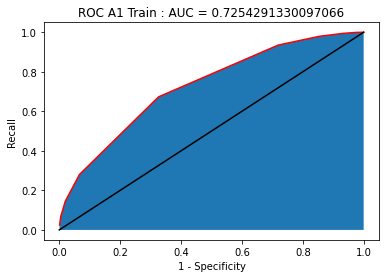

In [65]:
# Approach 1
plotROC(model1, trainDataset, 'A1 Train')

100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


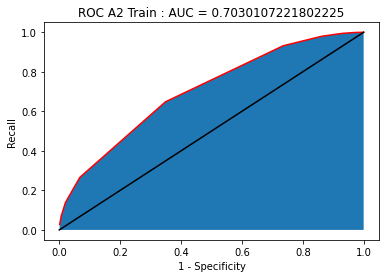

In [66]:
# Approach 2
plotROC(model2, trainDataset, 'A2 Train')

### Test dataset

100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


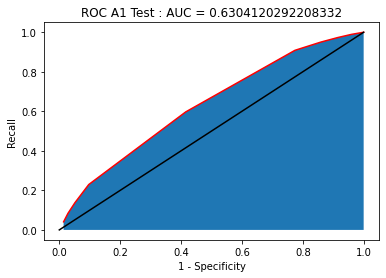

In [67]:
# Approach 1
plotROC(model1, testDataset, 'A1 Test')

100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


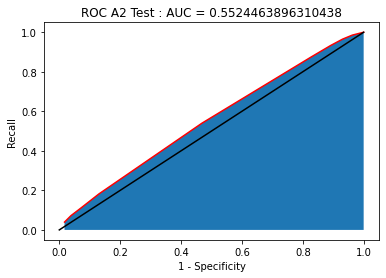

In [68]:
# Approach 2
plotROC(model2, testDataset, 'A2 Test')